<a href="https://colab.research.google.com/github/kenleejr/variational_inference/blob/main/Pyro_Hierarchical_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyro-ppl
!pip install wandb

In [3]:
import torch
import torch.distributions.constraints as constraints
from pyro.infer.autoguide.initialization import init_to_mean
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoGaussian, AutoLowRankMultivariateNormal
from pyro.infer import Predictive
import pyro.poutine as poutine
from pyro.poutine.util import prune_subsample_sites
from collections import defaultdict

from pyro.distributions.torch_transform import TransformModule

from functools import partial
import matplotlib.pyplot as plt
import wandb


import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use('fivethirtyeight')

In [4]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


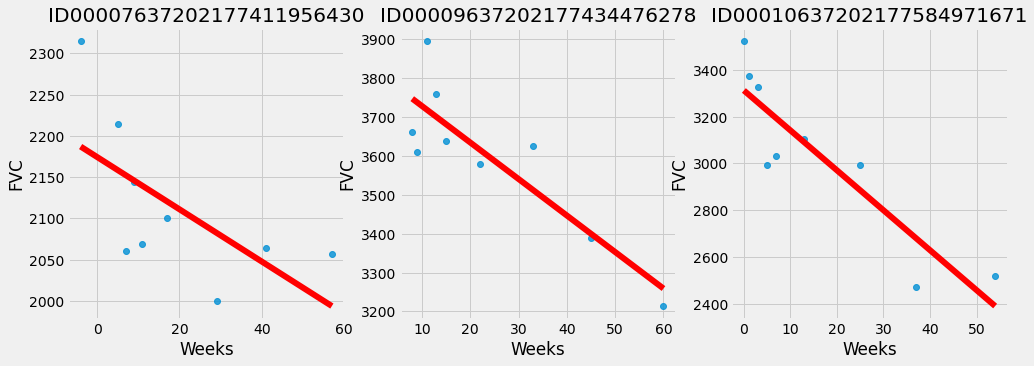

In [5]:
def chart(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    ax = sns.regplot(x, y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart("ID00007637202177411956430", axes[0])
chart("ID00009637202177434476278", axes[1])
chart("ID00010637202177584971671", axes[2])

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train["PatientID"] = le.fit_transform(train["Patient"].values)

FVC_obs = torch.tensor(train["FVC"].values)
Weeks = torch.tensor(train["Weeks"].values)
PatientID = torch.tensor(train["PatientID"].values)

In [7]:
pyro.clear_param_store()
def model(PatientID, Weeks, FVC_obs=None):
    μ_α = pyro.sample("μ_α", dist.Normal(0.0, 100.0))
    σ_α = pyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = pyro.sample("μ_β", dist.Normal(0.0, 100.0))
    σ_β = pyro.sample("σ_β", dist.HalfNormal(100.0))

    unique_patient_IDs = np.unique(PatientID)
    n_patients = len(unique_patient_IDs)

    with pyro.plate("plate_i", n_patients):
        α = pyro.sample("α", dist.Normal(μ_α, σ_α))
        β = pyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = pyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[PatientID] + β[PatientID] * Weeks

    with pyro.plate("data", len(PatientID)):
        pyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)


def guide(PatientID, Weeks, FVC_obs=None):
    global_μ_α = pyro.param("global_μ_α", torch.tensor(0.0))
    global_μ_β = pyro.param("global_μ_β", torch.tensor(0.0))
    global_σ_α = pyro.param("global_σ_α", torch.tensor(0.1), constraint=constraints.positive)
    global_σ_β = pyro.param("global_σ_β", torch.tensor(0.1), constraint=constraints.positive)

    μ_α = pyro.sample("μ_α", dist.Normal(global_μ_α, global_σ_α))
    μ_β = pyro.sample("μ_β", dist.Normal(global_μ_β, global_σ_β))
    σ_α = pyro.sample("σ_α", dist.HalfNormal(global_σ_α))
    σ_β = pyro.sample("σ_β", dist.HalfNormal(global_σ_β))
    
    global_σ = pyro.param("global_σ", torch.tensor(0.1), constraint=constraints.positive)
    σ = pyro.sample("σ", dist.HalfNormal(global_σ))

    n_patients = len(np.unique(PatientID))

    patient_mus = pyro.param("local_mus", torch.tensor(0.0).expand(2, n_patients))
    patient_scales = pyro.param("local_scales",
                                torch.tensor(0.1).expand(2, n_patients),
                                constraint=constraints.positive)

    with pyro.plate("plate_i", n_patients):
        pyro.sample("α", dist.Normal(patient_mus[0], patient_scales[0]))
        pyro.sample("β", dist.Normal(patient_mus[1], patient_scales[1]))

# Uncomment for different guides
# guide = AutoNormal(model)
# guide = AutoLowRankMultivariateNormal(model)

In [ ]:
traced_guide = poutine.trace(guide)
trace_obj = traced_guide.get_trace(PatientID, Weeks, FVC_obs)
for site in trace_obj.nodes.values():
    if site['type'] != 'args':
      print(site['name'], site['type'], site['value'])

In [16]:
wandb.init(project="pyro-hierarchical-regression", entity="kenleejr")

wandb.config.learning_rate = 0.003
wandb.config.epochs = 2000

svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": wandb.config.learning_rate}),
                     loss=pyro.infer.Trace_ELBO())

v_names = list(pyro.get_param_store().keys())

for t in range(wandb.config.epochs):
    elbo = svi.step(PatientID, Weeks, FVC_obs)

    elbo_dict = {"ELBO": elbo}
    wandb.log(elbo_dict)
    if t % 100 == 0:
      v_params = {v: pyro.param(v).data.numpy() for v in v_names}
      wandb.log(v_params)
    

ELBO,▁█▂▁▁▂▁▁▁▇▃▃▁▁▁▁▆▁▁▁▁▁▁▁▁▁▂▁▁▁▁▄▁▁▁▁▁▁▁▁
global_μ_α,▁▂▃▄▅▆▅█████████▅▅▅▅
global_μ_β,▁▁▃▃▃▃▄▄▅▅▅████▆▆▆▆▆
global_σ,▁▃▄▄▄▄▄▄▄▆▆▆▆▆▆▆▆███
global_σ_α,▁▂▃▃▄▄▅▆▆▆▆▆▆▆▆▆████
global_σ_β,▁▂▄▄▄▄▄▄▅▅▅▇▇▇▇█████
ELBO,1439096906145.4365
global_μ_α,0.10479
global_μ_β,0.16463
global_σ,0.1332
global_σ_α,0.13936


In [19]:
pred_template = []
for i in range(train["Patient"].nunique()):
    df = pd.DataFrame(columns=["PatientID", "Weeks"])
    df["Weeks"] = np.arange(-12, 134)
    df["PatientID"] = i
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

In [20]:
PatientID_predict = pred_template["PatientID"].values
Weeks_predict = pred_template["Weeks"].values
predictive = Predictive(model=model, guide=guide, num_samples=100)
samples_predictive = predictive(PatientID_predict, Weeks_predict, None)

In [21]:
df = pd.DataFrame(columns=["Patient", "Weeks", "FVC_pred", "sigma"])
df["Patient"] = le.inverse_transform(pred_template["PatientID"])
df["Weeks"] = pred_template["Weeks"]
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})

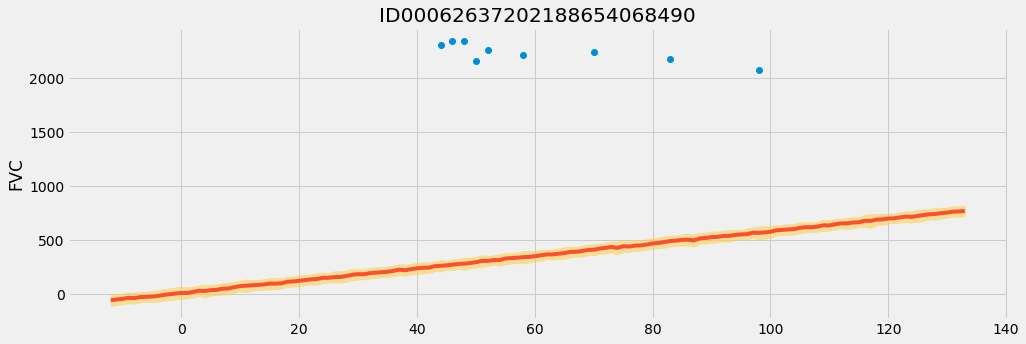

In [24]:
# Run for predictions

from pyro.primitives import random_module
def chart(patient_id, ax):
    data = df[df["Patient"] == patient_id]
    x = data["Weeks"]
    ax.set_title(patient_id)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    # ax = sns.regplot(x, data["FVC_true"], ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("FVC")

random_patient = df['Patient'].sample(n=1).iloc[0]
f, axes = plt.subplots(1, 1, figsize=(15, 5))
chart(random_patient, axes)
# chart("ID00007637202177411956430", axes[0])
# chart("ID00009637202177434476278", axes[1])
# chart("ID00011637202177653955184", axes[2])